In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/lxmert/requirements.txt

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-5i9x1wyz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-5i9x1wyz
  Resolved https://github.com/huggingface/transformers.git to commit 33868a057c02f0368ba63bd1edb746be38fe3d90
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.7/470.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.0/572.0 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done

In [ ]:
!pip install -q wget fiftyone

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.1/943.1 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/lxmert')

In [ ]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os
import torch.quantization as quant
from torch.nn.utils import prune

# Function to calculate and print model size
def print_model_size(model, description):
    size_in_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    size_in_mb = size_in_bytes / (1024 ** 2)
    print(f"{description} model size: {size_in_mb:.2f} MB")

# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_model = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")
# lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

# Print initial model size
print_model_size(lxmert_model, "Initial LXMERT")

### =============================
# Load LXMERT model and tokenizer
# Pruning function
def prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    return model

# Quantization function
def quantize_model(model):
    model.eval()  # Set model to evaluation mode for quantization
    quantized_model = quant.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )
    return quantized_model

# Prune and quantize the model
pruned_model = prune_model(lxmert_model)
print_model_size(pruned_model, "Pruned LXMERT")

quantized_model = quantize_model(pruned_model)
print_model_size(quantized_model, "Quantized LXMERT")

# Save the pruned and quantized model
torch.save(quantized_model.state_dict(), "quantized_pruned_lxmert_gqa.pth")

# Load pruned and quantized model (for verification)
quantized_model.load_state_dict(torch.load("quantized_pruned_lxmert_gqa.pth"))

### =============================

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml /root/.cache/torch/transformers/tmpq6s18vfj


Downloading:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmp66onfsub


Downloading:   0%|          | 0.00/262M [00:00<?, ?B/s]

loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/content/drive/MyDrive/lxmert/modeling_frcnn.py:1750: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map_location="cpu")


All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/848M [00:00<?, ?B/s]

Initial LXMERT model size: 808.53 MB
Pruned LXMERT model size: 808.53 MB
Quantized LXMERT model size: 91.27 MB


<ipython-input-6-76ff6f4f201e>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantized_model.load_state_dict(torch.load("quantized_pruned_lxmert_gqa.pth"))
/usr/local/li

<All keys matched successfully>

pruning, quantisation

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
import pickle
import numpy as np
import os

# File path to save pickle on Google Drive
pickle_path = "/content/drive/MyDrive/lxmert_quantized_predictions_confidence.pkl"

# Load previous progress if available
try:
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
        lxmert_predictions = data["lxmert_predictions"]
        quantized_predictions = data["quantized_predictions"]
        lxmert_confidences = data["lxmert_confidences"]
        quantized_confidences = data["quantized_confidences"]
        start_idx = len(lxmert_predictions)
        print(f"Resuming from index {start_idx}")
except FileNotFoundError:
    lxmert_predictions, quantized_predictions = [], []
    lxmert_confidences, quantized_confidences = [], []
    start_idx = 0
    print("Starting from scratch")

# URL for the image and other data
list1 = np.load('/content/drive/MyDrive/image_list.npy')

OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

# Load labels
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
gqa_answers = utils.get_data(GQA_URL)
vqa_answers = utils.get_data(VQA_URL)

# Iterate over each item in list1 with progress tracking
for idx, item in enumerate(tqdm(list1[start_idx:], desc="Processing images", initial=start_idx, total=len(list1))):
    URL = "http://images.cocodataset.org/train2017/" + item
    print(f"Processing URL: {URL}")

    # Preprocess the image and get output dictionary
    images, sizes, scales_yx = image_preprocess(URL)
    output_dict = frcnn(
        images,
        sizes,
        scales_yx=scales_yx,
        padding="max_detections",
        max_detections=frcnn_cfg.max_detections,
        return_tensors="pt",
    )

    # Define questions for the image
    test_questions_for_url = ["what all is there in the image?"]

    normalized_boxes = output_dict.get("normalized_boxes")
    features = output_dict.get("roi_features")

    # Run inference for each question and record predictions
    for test_question in test_questions_for_url:
        test_question = [test_question]
        inputs = lxmert_tokenizer(
            test_question,
            padding="max_length",
            max_length=20,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt",
        )

        # Run original LXMERT
        lxmert_output = lxmert_model(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=normalized_boxes,
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )

        # Run pruned/quantized LXMERT
        quantized_output = quantized_model(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=normalized_boxes,
            token_type_ids=inputs.token_type_ids,
            output_attentions=False,
        )

        # Get predictions
        lxmert_pred = lxmert_output["question_answering_score"].argmax(-1).item()
        quantized_pred = quantized_output["question_answering_score"].argmax(-1).item()

        # Calculate confidence
        lxmert_confidence = torch.softmax(lxmert_output["question_answering_score"], dim=-1).max().item()
        quantized_confidence = torch.softmax(quantized_output["question_answering_score"], dim=-1).max().item()

        # Append to lists
        lxmert_predictions.append(lxmert_pred)
        quantized_predictions.append(quantized_pred)
        lxmert_confidences.append(lxmert_confidence)
        quantized_confidences.append(quantized_confidence)

    # Save current progress to Google Drive after each iteration
    with open(pickle_path, "wb") as f:
        pickle.dump({
            "lxmert_predictions": lxmert_predictions,
            "quantized_predictions": quantized_predictions,
            "lxmert_confidences": lxmert_confidences,
            "quantized_confidences": quantized_confidences,
        }, f)

    # Print the index of the last processed item
    print("Last processed index:", idx + start_idx)

# Calculate agreement rate
agreement_rate = accuracy_score(lxmert_predictions, quantized_predictions)
print("Agreement Rate between LXMERT and Quantized LXMERT:", agreement_rate)

# Calculate average confidence for each model
avg_lxmert_confidence = sum(lxmert_confidences) / len(lxmert_confidences)
avg_quantized_confidence = sum(quantized_confidences) / len(quantized_confidences)

print("Average Confidence of LXMERT:", avg_lxmert_confidence)
print("Average Confidence of Quantized LXMERT:", avg_quantized_confidence)


Resuming from index 175


Processing images:  35%|███▌      | 175/500 [00:00<?, ?it/s]

Processing URL: http://images.cocodataset.org/train2017/000000000471.jpg


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Processing images:  35%|███▌      | 176/500 [00:30<2:43:06, 30.21s/it]

Last processed index: 175
Processing URL: http://images.cocodataset.org/train2017/000000001592.jpg


Processing images:  35%|███▌      | 177/500 [00:56<2:30:47, 28.01s/it]

Last processed index: 176
Processing URL: http://images.cocodataset.org/train2017/000000001586.jpg


Processing images:  36%|███▌      | 178/500 [01:26<2:33:39, 28.63s/it]

Last processed index: 177
Processing URL: http://images.cocodataset.org/train2017/000000000897.jpg


Processing images:  36%|███▌      | 179/500 [01:48<2:20:31, 26.27s/it]

Last processed index: 178
Processing URL: http://images.cocodataset.org/train2017/000000001237.jpg


Processing images:  36%|███▌      | 180/500 [02:12<2:16:03, 25.51s/it]

Last processed index: 179
Processing URL: http://images.cocodataset.org/train2017/000000000673.jpg


Processing images:  36%|███▌      | 181/500 [02:45<2:27:52, 27.81s/it]

Last processed index: 180
Processing URL: http://images.cocodataset.org/train2017/000000001579.jpg


Processing images:  36%|███▋      | 182/500 [03:06<2:15:46, 25.62s/it]

Last processed index: 181
Processing URL: http://images.cocodataset.org/train2017/000000001569.jpg


Processing images:  37%|███▋      | 183/500 [03:35<2:20:58, 26.68s/it]

Last processed index: 182
Processing URL: http://images.cocodataset.org/train2017/000000001596.jpg


Processing images:  37%|███▋      | 184/500 [03:54<2:08:32, 24.41s/it]

Last processed index: 183
Processing URL: http://images.cocodataset.org/train2017/000000001025.jpg


Processing images:  37%|███▋      | 185/500 [04:21<2:12:17, 25.20s/it]

Last processed index: 184
Processing URL: http://images.cocodataset.org/train2017/000000001757.jpg


Processing images:  37%|███▋      | 186/500 [04:47<2:12:32, 25.33s/it]

Last processed index: 185
Processing URL: http://images.cocodataset.org/train2017/000000000307.jpg


Processing images:  37%|███▋      | 187/500 [05:10<2:08:24, 24.61s/it]

Last processed index: 186
Processing URL: http://images.cocodataset.org/train2017/000000002276.jpg


Processing images:  38%|███▊      | 188/500 [05:31<2:02:30, 23.56s/it]

Last processed index: 187
Processing URL: http://images.cocodataset.org/train2017/000000001958.jpg


Processing images:  38%|███▊      | 189/500 [05:55<2:02:44, 23.68s/it]

Last processed index: 188
Processing URL: http://images.cocodataset.org/train2017/000000000529.jpg


Processing images:  38%|███▊      | 190/500 [06:19<2:03:50, 23.97s/it]

Last processed index: 189
Processing URL: http://images.cocodataset.org/train2017/000000001637.jpg


Processing images:  38%|███▊      | 191/500 [06:51<2:15:50, 26.38s/it]

Last processed index: 190
Processing URL: http://images.cocodataset.org/train2017/000000001145.jpg


Processing images:  38%|███▊      | 192/500 [07:16<2:12:40, 25.85s/it]

Last processed index: 191
Processing URL: http://images.cocodataset.org/train2017/000000002302.jpg


Processing images:  39%|███▊      | 193/500 [07:43<2:13:37, 26.12s/it]

Last processed index: 192
Processing URL: http://images.cocodataset.org/train2017/000000002470.jpg


Processing images:  39%|███▉      | 194/500 [08:06<2:08:53, 25.27s/it]

Last processed index: 193
Processing URL: http://images.cocodataset.org/train2017/000000001810.jpg


Processing images:  39%|███▉      | 195/500 [08:27<2:02:14, 24.05s/it]

Last processed index: 194
Processing URL: http://images.cocodataset.org/train2017/000000001804.jpg


Processing images:  39%|███▉      | 196/500 [08:50<1:59:48, 23.65s/it]

Last processed index: 195
Processing URL: http://images.cocodataset.org/train2017/000000001347.jpg


Processing images:  39%|███▉      | 197/500 [09:16<2:02:23, 24.23s/it]

Last processed index: 196
Processing URL: http://images.cocodataset.org/train2017/000000000071.jpg


Processing images:  40%|███▉      | 198/500 [09:50<2:18:07, 27.44s/it]

Last processed index: 197
Processing URL: http://images.cocodataset.org/train2017/000000002114.jpg


Processing images:  40%|███▉      | 199/500 [10:35<2:43:53, 32.67s/it]

Last processed index: 198
Processing URL: http://images.cocodataset.org/train2017/000000001390.jpg


Processing images:  40%|████      | 200/500 [11:01<2:32:48, 30.56s/it]

Last processed index: 199
Processing URL: http://images.cocodataset.org/train2017/000000000925.jpg


Processing images:  40%|████      | 201/500 [11:21<2:17:08, 27.52s/it]

Last processed index: 200
Processing URL: http://images.cocodataset.org/train2017/000000000064.jpg


Processing images:  40%|████      | 202/500 [11:45<2:10:06, 26.20s/it]

Last processed index: 201
Processing URL: http://images.cocodataset.org/train2017/000000000716.jpg


Processing images:  41%|████      | 203/500 [12:11<2:09:41, 26.20s/it]

Last processed index: 202
Processing URL: http://images.cocodataset.org/train2017/000000001408.jpg


Processing images:  41%|████      | 204/500 [12:47<2:23:38, 29.12s/it]

Last processed index: 203
Processing URL: http://images.cocodataset.org/train2017/000000001811.jpg


Processing images:  41%|████      | 205/500 [13:16<2:23:00, 29.09s/it]

Last processed index: 204
Processing URL: http://images.cocodataset.org/train2017/000000000514.jpg


Processing images:  41%|████      | 206/500 [13:37<2:10:40, 26.67s/it]

Last processed index: 205
Processing URL: http://images.cocodataset.org/train2017/000000001622.jpg


Processing images:  41%|████▏     | 207/500 [13:58<2:02:08, 25.01s/it]

Last processed index: 206
Processing URL: http://images.cocodataset.org/train2017/000000001144.jpg


Processing images:  42%|████▏     | 208/500 [14:29<2:11:12, 26.96s/it]

Last processed index: 207
Processing URL: http://images.cocodataset.org/train2017/000000002459.jpg


Processing images:  42%|████▏     | 209/500 [14:51<2:03:06, 25.38s/it]

Last processed index: 208
Processing URL: http://images.cocodataset.org/train2017/000000001781.jpg


Processing images:  42%|████▏     | 210/500 [15:15<2:00:15, 24.88s/it]

Last processed index: 209
Processing URL: http://images.cocodataset.org/train2017/000000000474.jpg


Processing images:  42%|████▏     | 211/500 [15:36<1:54:41, 23.81s/it]

Last processed index: 210
Processing URL: http://images.cocodataset.org/train2017/000000000312.jpg


Processing images:  42%|████▏     | 212/500 [16:03<1:59:22, 24.87s/it]

Last processed index: 211
Processing URL: http://images.cocodataset.org/train2017/000000001756.jpg


Processing images:  43%|████▎     | 213/500 [16:38<2:12:40, 27.74s/it]

Last processed index: 212
Processing URL: http://images.cocodataset.org/train2017/000000000110.jpg


Processing images:  43%|████▎     | 214/500 [17:02<2:06:50, 26.61s/it]

Last processed index: 213
Processing URL: http://images.cocodataset.org/train2017/000000002061.jpg


Processing images:  43%|████▎     | 215/500 [17:25<2:01:44, 25.63s/it]

Last processed index: 214
Processing URL: http://images.cocodataset.org/train2017/000000001232.jpg


Processing images:  43%|████▎     | 216/500 [18:01<2:15:53, 28.71s/it]

Last processed index: 215
Processing URL: http://images.cocodataset.org/train2017/000000001554.jpg


Processing images:  43%|████▎     | 217/500 [18:26<2:10:40, 27.71s/it]

Last processed index: 216
Processing URL: http://images.cocodataset.org/train2017/000000000138.jpg


Processing images:  44%|████▎     | 218/500 [19:01<2:20:26, 29.88s/it]

Last processed index: 217
Processing URL: http://images.cocodataset.org/train2017/000000001224.jpg


Processing images:  44%|████▍     | 219/500 [19:27<2:14:27, 28.71s/it]

Last processed index: 218
Processing URL: http://images.cocodataset.org/train2017/000000000853.jpg


Processing images:  44%|████▍     | 220/500 [19:48<2:02:48, 26.32s/it]

Last processed index: 219
Processing URL: http://images.cocodataset.org/train2017/000000000338.jpg


Processing images:  44%|████▍     | 221/500 [20:18<2:07:28, 27.41s/it]

Last processed index: 220
Processing URL: http://images.cocodataset.org/train2017/000000001146.jpg


Processing images:  44%|████▍     | 222/500 [20:40<1:59:03, 25.70s/it]

Last processed index: 221
Processing URL: http://images.cocodataset.org/train2017/000000002315.jpg


Processing images:  45%|████▍     | 223/500 [21:15<2:11:44, 28.54s/it]

Last processed index: 222
Processing URL: http://images.cocodataset.org/train2017/000000000502.jpg


Processing images:  45%|████▍     | 224/500 [21:39<2:04:36, 27.09s/it]

Last processed index: 223
Processing URL: http://images.cocodataset.org/train2017/000000001813.jpg


Processing images:  45%|████▌     | 225/500 [21:58<1:53:45, 24.82s/it]

Last processed index: 224
Processing URL: http://images.cocodataset.org/train2017/000000001350.jpg


Processing images:  45%|████▌     | 226/500 [22:25<1:56:21, 25.48s/it]

Last processed index: 225
Processing URL: http://images.cocodataset.org/train2017/000000001436.jpg


Processing images:  45%|████▌     | 227/500 [22:51<1:56:22, 25.58s/it]

Last processed index: 226
Processing URL: http://images.cocodataset.org/train2017/000000000072.jpg


Processing images:  46%|████▌     | 228/500 [23:18<1:58:08, 26.06s/it]

Last processed index: 227
Processing URL: http://images.cocodataset.org/train2017/000000000714.jpg


Processing images:  46%|████▌     | 229/500 [23:47<2:01:36, 26.92s/it]

Last processed index: 228
Processing URL: http://images.cocodataset.org/train2017/000000000927.jpg


Processing images:  46%|████▌     | 230/500 [24:17<2:05:41, 27.93s/it]

Last processed index: 229
Processing URL: http://images.cocodataset.org/train2017/000000001393.jpg


Processing images:  46%|████▌     | 231/500 [24:39<1:56:37, 26.01s/it]

Last processed index: 230
Processing URL: http://images.cocodataset.org/train2017/000000001392.jpg


Processing images:  46%|████▋     | 232/500 [24:59<1:48:01, 24.19s/it]

Last processed index: 231
Processing URL: http://images.cocodataset.org/train2017/000000001386.jpg


Processing images:  47%|████▋     | 233/500 [25:21<1:45:25, 23.69s/it]

Last processed index: 232
Processing URL: http://images.cocodataset.org/train2017/000000000073.jpg


Processing images:  47%|████▋     | 234/500 [25:42<1:40:46, 22.73s/it]

Last processed index: 233
Processing URL: http://images.cocodataset.org/train2017/000000000715.jpg


Processing images:  47%|████▋     | 235/500 [26:08<1:45:11, 23.82s/it]

Last processed index: 234
Processing URL: http://images.cocodataset.org/train2017/000000002466.jpg


Processing images:  47%|████▋     | 236/500 [26:38<1:53:02, 25.69s/it]

Last processed index: 235
Processing URL: http://images.cocodataset.org/train2017/000000001153.jpg


Processing images:  47%|████▋     | 237/500 [27:03<1:51:02, 25.33s/it]

Last processed index: 236
Processing URL: http://images.cocodataset.org/train2017/000000001966.jpg


Processing images:  48%|████▊     | 238/500 [27:28<1:49:55, 25.18s/it]

Last processed index: 237
Processing URL: http://images.cocodataset.org/train2017/000000000488.jpg


Processing images:  48%|████▊     | 239/500 [28:11<2:13:14, 30.63s/it]

Last processed index: 238
Processing URL: http://images.cocodataset.org/train2017/000000001999.jpg


Processing images:  48%|████▊     | 240/500 [28:37<2:07:02, 29.32s/it]

Last processed index: 239
Processing URL: http://images.cocodataset.org/train2017/000000001580.jpg


Processing images:  48%|████▊     | 241/500 [29:08<2:08:12, 29.70s/it]

Last processed index: 240
Processing URL: http://images.cocodataset.org/train2017/000000002089.jpg


Processing images:  48%|████▊     | 242/500 [29:37<2:07:34, 29.67s/it]

Last processed index: 241
Processing URL: http://images.cocodataset.org/train2017/000000000661.jpg


Processing images:  49%|████▊     | 243/500 [30:00<1:57:51, 27.51s/it]

Last processed index: 242
Processing URL: http://images.cocodataset.org/train2017/000000000675.jpg


Processing images:  49%|████▉     | 244/500 [30:23<1:51:52, 26.22s/it]

Last processed index: 243
Processing URL: http://images.cocodataset.org/train2017/000000000113.jpg


Processing images:  49%|████▉     | 245/500 [30:47<1:48:17, 25.48s/it]

Last processed index: 244
Processing URL: http://images.cocodataset.org/train2017/000000001228.jpg


Processing images:  49%|████▉     | 246/500 [31:11<1:46:16, 25.10s/it]

Last processed index: 245
Processing URL: http://images.cocodataset.org/train2017/000000000136.jpg


Processing images:  49%|████▉     | 247/500 [31:36<1:46:11, 25.18s/it]

Last processed index: 246
Processing URL: http://images.cocodataset.org/train2017/000000000650.jpg


Processing images:  50%|████▉     | 248/500 [32:01<1:44:34, 24.90s/it]

Last processed index: 247
Processing URL: http://images.cocodataset.org/train2017/000000001200.jpg


Processing images:  50%|████▉     | 249/500 [32:27<1:45:29, 25.22s/it]

Last processed index: 248
Processing URL: http://images.cocodataset.org/train2017/000000000693.jpg


Processing images:  50%|█████     | 250/500 [32:55<1:48:48, 26.11s/it]

Last processed index: 249
Processing URL: http://images.cocodataset.org/train2017/000000001599.jpg


Processing images:  50%|█████     | 251/500 [33:36<2:07:03, 30.62s/it]

Last processed index: 250
Processing URL: http://images.cocodataset.org/train2017/000000001994.jpg


Processing images:  50%|█████     | 252/500 [33:58<1:55:26, 27.93s/it]

Last processed index: 251
Processing URL: http://images.cocodataset.org/train2017/000000000446.jpg


Processing images:  51%|█████     | 253/500 [34:21<1:49:52, 26.69s/it]

Last processed index: 252
Processing URL: http://images.cocodataset.org/train2017/000000002279.jpg


Processing images:  51%|█████     | 254/500 [34:46<1:47:19, 26.18s/it]

Last processed index: 253
Processing URL: http://images.cocodataset.org/train2017/000000000308.jpg


Processing images:  51%|█████     | 255/500 [35:16<1:51:31, 27.31s/it]

Last processed index: 254
Processing URL: http://images.cocodataset.org/train2017/000000001764.jpg


Processing images:  51%|█████     | 256/500 [35:52<2:01:38, 29.91s/it]

Last processed index: 255
Processing URL: http://images.cocodataset.org/train2017/000000000491.jpg


Processing images:  51%|█████▏    | 257/500 [36:16<1:53:38, 28.06s/it]

Last processed index: 256
Processing URL: http://images.cocodataset.org/train2017/000000001943.jpg


Processing images:  52%|█████▏    | 258/500 [36:51<2:01:08, 30.04s/it]

Last processed index: 257
Processing URL: http://images.cocodataset.org/train2017/000000000532.jpg


Processing images:  52%|█████▏    | 259/500 [37:21<2:01:00, 30.13s/it]

Last processed index: 258
Processing URL: http://images.cocodataset.org/train2017/000000001176.jpg


Processing images:  52%|█████▏    | 260/500 [37:45<1:52:50, 28.21s/it]

Last processed index: 259
Processing URL: http://images.cocodataset.org/train2017/000000000283.jpg


Processing images:  52%|█████▏    | 261/500 [38:06<1:44:03, 26.13s/it]

Last processed index: 260
Processing URL: http://images.cocodataset.org/train2017/000000001837.jpg


Processing images:  52%|█████▏    | 262/500 [38:36<1:48:14, 27.29s/it]

Last processed index: 261
Processing URL: http://images.cocodataset.org/train2017/000000000042.jpg


Processing images:  53%|█████▎    | 263/500 [39:02<1:46:37, 26.99s/it]

Last processed index: 262
Processing URL: http://images.cocodataset.org/train2017/000000000730.jpg


Processing images:  53%|█████▎    | 264/500 [39:34<1:52:12, 28.53s/it]

Last processed index: 263
Processing URL: http://images.cocodataset.org/train2017/000000001360.jpg


Processing images:  53%|█████▎    | 265/500 [40:01<1:48:51, 27.79s/it]

Last processed index: 264
Processing URL: http://images.cocodataset.org/train2017/000000001374.jpg


Processing images:  53%|█████▎    | 266/500 [40:29<1:48:50, 27.91s/it]

Last processed index: 265
Processing URL: http://images.cocodataset.org/train2017/000000000081.jpg


Processing images:  53%|█████▎    | 267/500 [40:50<1:41:02, 26.02s/it]

Last processed index: 266
Processing URL: http://images.cocodataset.org/train2017/000000000902.jpg


Processing images:  54%|█████▎    | 268/500 [41:17<1:41:37, 26.28s/it]

Last processed index: 267
Processing URL: http://images.cocodataset.org/train2017/000000000094.jpg


Processing images:  54%|█████▍    | 269/500 [41:48<1:46:03, 27.55s/it]

Last processed index: 268
Processing URL: http://images.cocodataset.org/train2017/000000001375.jpg


Processing images:  54%|█████▍    | 270/500 [42:14<1:44:10, 27.18s/it]

Last processed index: 269
Processing URL: http://images.cocodataset.org/train2017/000000001407.jpg


Processing images:  54%|█████▍    | 271/500 [42:36<1:37:16, 25.49s/it]

Last processed index: 270
Processing URL: http://images.cocodataset.org/train2017/000000000731.jpg


Processing images:  54%|█████▍    | 272/500 [43:09<1:45:51, 27.86s/it]

Last processed index: 271
Processing URL: http://images.cocodataset.org/train2017/000000001822.jpg


Processing images:  55%|█████▍    | 273/500 [43:37<1:45:24, 27.86s/it]

Last processed index: 272
Processing URL: http://images.cocodataset.org/train2017/000000001611.jpg


Processing images:  55%|█████▍    | 274/500 [44:10<1:50:40, 29.38s/it]

Last processed index: 273
Processing URL: http://images.cocodataset.org/train2017/000000001639.jpg


Processing images:  55%|█████▌    | 275/500 [44:36<1:46:30, 28.40s/it]

Last processed index: 274
Processing URL: http://images.cocodataset.org/train2017/000000000241.jpg


Processing images:  55%|█████▌    | 276/500 [45:02<1:43:48, 27.81s/it]

Last processed index: 275
Processing URL: http://images.cocodataset.org/train2017/000000001942.jpg


Processing images:  55%|█████▌    | 277/500 [45:20<1:31:34, 24.64s/it]

Last processed index: 276
Processing URL: http://images.cocodataset.org/train2017/000000000490.jpg


Processing images:  56%|█████▌    | 278/500 [45:41<1:27:46, 23.72s/it]

Last processed index: 277
Processing URL: http://images.cocodataset.org/train2017/000000001771.jpg


Processing images:  56%|█████▌    | 279/500 [46:08<1:31:19, 24.79s/it]

Last processed index: 278
Processing URL: http://images.cocodataset.org/train2017/000000002278.jpg


Processing images:  56%|█████▌    | 280/500 [46:31<1:28:50, 24.23s/it]

Last processed index: 279
Processing URL: http://images.cocodataset.org/train2017/000000000309.jpg


Processing images:  56%|█████▌    | 281/500 [46:54<1:26:41, 23.75s/it]

Last processed index: 280
Processing URL: http://images.cocodataset.org/train2017/000000000321.jpg


Processing images:  56%|█████▋    | 282/500 [47:15<1:22:56, 22.83s/it]

Last processed index: 281
Processing URL: http://images.cocodataset.org/train2017/000000002244.jpg


Processing images:  57%|█████▋    | 283/500 [47:35<1:20:12, 22.18s/it]

Last processed index: 282
Processing URL: http://images.cocodataset.org/train2017/000000000692.jpg


Processing images:  57%|█████▋    | 284/500 [47:59<1:21:32, 22.65s/it]

Last processed index: 283
Processing URL: http://images.cocodataset.org/train2017/000000001573.jpg


Processing images:  57%|█████▋    | 285/500 [48:24<1:23:56, 23.43s/it]

Last processed index: 284
Processing URL: http://images.cocodataset.org/train2017/000000000109.jpg


Processing images:  57%|█████▋    | 286/500 [49:00<1:36:18, 27.00s/it]

Last processed index: 285
Processing URL: http://images.cocodataset.org/train2017/000000002093.jpg


Processing images:  57%|█████▋    | 287/500 [49:23<1:31:35, 25.80s/it]

Last processed index: 286
Processing URL: http://images.cocodataset.org/train2017/000000000684.jpg


Processing images:  58%|█████▊    | 288/500 [49:43<1:25:24, 24.17s/it]

Last processed index: 287
Processing URL: http://images.cocodataset.org/train2017/000000000690.jpg


Processing images:  58%|█████▊    | 289/500 [50:15<1:33:29, 26.59s/it]

Last processed index: 288
Processing URL: http://images.cocodataset.org/train2017/000000001029.jpg


Processing images:  58%|█████▊    | 290/500 [50:36<1:26:34, 24.74s/it]

Last processed index: 289
Processing URL: http://images.cocodataset.org/train2017/000000001997.jpg


Processing images:  58%|█████▊    | 291/500 [50:59<1:25:01, 24.41s/it]

Last processed index: 290
Processing URL: http://images.cocodataset.org/train2017/000000000486.jpg


Processing images:  58%|█████▊    | 292/500 [51:28<1:28:46, 25.61s/it]

Last processed index: 291
Processing URL: http://images.cocodataset.org/train2017/000000000531.jpg


Processing images:  59%|█████▊    | 293/500 [52:04<1:39:27, 28.83s/it]

Last processed index: 292
Processing URL: http://images.cocodataset.org/train2017/000000001149.jpg


Processing images:  59%|█████▉    | 294/500 [52:37<1:43:04, 30.02s/it]

Last processed index: 293
Processing URL: http://images.cocodataset.org/train2017/000000000257.jpg


Processing images:  59%|█████▉    | 295/500 [53:21<1:57:19, 34.34s/it]

Last processed index: 294
Processing URL: http://images.cocodataset.org/train2017/000000000294.jpg


Processing images:  59%|█████▉    | 296/500 [53:47<1:47:41, 31.68s/it]

Last processed index: 295
Processing URL: http://images.cocodataset.org/train2017/000000002124.jpg


Processing images:  59%|█████▉    | 297/500 [54:23<1:51:23, 32.92s/it]

Last processed index: 296
Processing URL: http://images.cocodataset.org/train2017/000000000901.jpg


Processing images:  60%|█████▉    | 298/500 [54:50<1:45:39, 31.38s/it]

Last processed index: 297
Processing URL: http://images.cocodataset.org/train2017/000000001404.jpg


Processing images:  60%|█████▉    | 299/500 [55:11<1:34:32, 28.22s/it]

Last processed index: 298
Processing URL: http://images.cocodataset.org/train2017/000000001955.jpg


Processing images:  60%|██████    | 300/500 [55:37<1:31:12, 27.36s/it]

Last processed index: 299
Processing URL: http://images.cocodataset.org/train2017/000000002284.jpg


Processing images:  60%|██████    | 301/500 [56:02<1:28:24, 26.66s/it]

Last processed index: 300
Processing URL: http://images.cocodataset.org/train2017/000000002290.jpg


Processing images:  60%|██████    | 302/500 [56:24<1:23:28, 25.29s/it]

Last processed index: 301
Processing URL: http://images.cocodataset.org/train2017/000000001799.jpg


Processing images:  61%|██████    | 303/500 [56:52<1:26:20, 26.30s/it]

Last processed index: 302
Processing URL: http://images.cocodataset.org/train2017/000000001941.jpg


Processing images:  61%|██████    | 304/500 [57:22<1:29:18, 27.34s/it]

Last processed index: 303
Processing URL: http://images.cocodataset.org/train2017/000000001014.jpg


Processing images:  61%|██████    | 305/500 [57:49<1:28:38, 27.28s/it]

Last processed index: 304
Processing URL: http://images.cocodataset.org/train2017/000000000450.jpg


Processing images:  61%|██████    | 306/500 [58:09<1:21:14, 25.13s/it]

Last processed index: 305
Processing URL: http://images.cocodataset.org/train2017/000000000322.jpg


Processing images:  61%|██████▏   | 307/500 [58:33<1:19:12, 24.62s/it]

Last processed index: 306
Processing URL: http://images.cocodataset.org/train2017/000000001216.jpg


Processing images:  62%|██████▏   | 308/500 [59:04<1:24:40, 26.46s/it]

Last processed index: 307
Processing URL: http://images.cocodataset.org/train2017/000000001558.jpg


Processing images:  62%|██████▏   | 309/500 [59:24<1:18:03, 24.52s/it]

Last processed index: 308
Processing URL: http://images.cocodataset.org/train2017/000000002055.jpg


Processing images:  62%|██████▏   | 310/500 [59:43<1:13:14, 23.13s/it]

Last processed index: 309
Processing URL: http://images.cocodataset.org/train2017/000000000656.jpg


Processing images:  62%|██████▏   | 311/500 [1:00:07<1:12:49, 23.12s/it]

Last processed index: 310
Processing URL: http://images.cocodataset.org/train2017/000000001548.jpg


Processing images:  62%|██████▏   | 312/500 [1:00:33<1:15:28, 24.09s/it]

Last processed index: 311
Processing URL: http://images.cocodataset.org/train2017/000000000681.jpg


Processing images:  63%|██████▎   | 313/500 [1:00:55<1:13:22, 23.54s/it]

Last processed index: 312
Processing URL: http://images.cocodataset.org/train2017/000000001762.jpg


Processing images:  63%|██████▎   | 314/500 [1:01:21<1:15:08, 24.24s/it]

Last processed index: 313
Processing URL: http://images.cocodataset.org/train2017/000000000326.jpg


Processing images:  63%|██████▎   | 315/500 [1:01:43<1:12:19, 23.46s/it]

Last processed index: 314
Processing URL: http://images.cocodataset.org/train2017/000000000332.jpg


Processing images:  63%|██████▎   | 316/500 [1:02:05<1:10:45, 23.07s/it]

Last processed index: 315
Processing URL: http://images.cocodataset.org/train2017/000000002280.jpg


Processing images:  63%|██████▎   | 317/500 [1:02:31<1:13:24, 24.07s/it]

Last processed index: 316
Processing URL: http://images.cocodataset.org/train2017/000000000508.jpg


Processing images:  64%|██████▎   | 318/500 [1:03:04<1:20:39, 26.59s/it]

Last processed index: 317
Processing URL: http://images.cocodataset.org/train2017/000000001164.jpg


Processing images:  64%|██████▍   | 319/500 [1:03:36<1:25:50, 28.46s/it]

Last processed index: 318
Processing URL: http://images.cocodataset.org/train2017/000000002445.jpg


Processing images:  64%|██████▍   | 320/500 [1:03:57<1:18:35, 26.20s/it]

Last processed index: 319
Processing URL: http://images.cocodataset.org/train2017/000000000520.jpg


Processing images:  64%|██████▍   | 321/500 [1:04:36<1:29:08, 29.88s/it]

Last processed index: 320
Processing URL: http://images.cocodataset.org/train2017/000000002337.jpg


Processing images:  64%|██████▍   | 322/500 [1:04:57<1:20:52, 27.26s/it]

Last processed index: 321
Processing URL: http://images.cocodataset.org/train2017/000000002451.jpg


Processing images:  65%|██████▍   | 323/500 [1:05:24<1:20:18, 27.22s/it]

Last processed index: 322
Processing URL: http://images.cocodataset.org/train2017/000000000078.jpg


Processing images:  65%|██████▍   | 324/500 [1:05:45<1:14:21, 25.35s/it]

Last processed index: 323
Processing URL: http://images.cocodataset.org/train2017/000000001366.jpg


Processing images:  65%|██████▌   | 325/500 [1:06:15<1:17:34, 26.60s/it]

Last processed index: 324
Processing URL: http://images.cocodataset.org/train2017/000000002135.jpg


Processing images:  65%|██████▌   | 326/500 [1:06:40<1:15:54, 26.17s/it]

Last processed index: 325
Processing URL: http://images.cocodataset.org/train2017/000000000722.jpg


Processing images:  65%|██████▌   | 327/500 [1:07:25<1:31:37, 31.78s/it]

Last processed index: 326
Processing URL: http://images.cocodataset.org/train2017/000000000939.jpg


Processing images:  66%|██████▌   | 328/500 [1:07:50<1:25:43, 29.91s/it]

Last processed index: 327
Processing URL: http://images.cocodataset.org/train2017/000000000086.jpg


Processing images:  66%|██████▌   | 329/500 [1:08:12<1:18:41, 27.61s/it]

Last processed index: 328
Processing URL: http://images.cocodataset.org/train2017/000000001398.jpg


Processing images:  66%|██████▌   | 330/500 [1:08:32<1:11:16, 25.15s/it]

Last processed index: 329
Processing URL: http://images.cocodataset.org/train2017/000000000092.jpg


Processing images:  66%|██████▌   | 331/500 [1:08:54<1:08:32, 24.33s/it]

Last processed index: 330
Processing URL: http://images.cocodataset.org/train2017/000000000723.jpg


Processing images:  66%|██████▋   | 332/500 [1:09:19<1:08:25, 24.44s/it]

Last processed index: 331
Processing URL: http://images.cocodataset.org/train2017/000000001401.jpg


Processing images:  67%|██████▋   | 333/500 [1:09:41<1:05:56, 23.69s/it]

Last processed index: 332
Processing URL: http://images.cocodataset.org/train2017/000000000247.jpg


Processing images:  67%|██████▋   | 334/500 [1:10:14<1:13:34, 26.59s/it]

Last processed index: 333
Processing URL: http://images.cocodataset.org/train2017/000000002444.jpg


Processing images:  67%|██████▋   | 335/500 [1:10:44<1:15:57, 27.62s/it]

Last processed index: 334
Processing URL: http://images.cocodataset.org/train2017/000000001171.jpg


Processing images:  67%|██████▋   | 336/500 [1:11:12<1:15:55, 27.78s/it]

Last processed index: 335
Processing URL: http://images.cocodataset.org/train2017/000000002281.jpg


Processing images:  67%|██████▋   | 337/500 [1:11:35<1:10:58, 26.13s/it]

Last processed index: 336
Processing URL: http://images.cocodataset.org/train2017/000000002295.jpg


Processing images:  68%|██████▊   | 338/500 [1:11:56<1:06:54, 24.78s/it]

Last processed index: 337
Processing URL: http://images.cocodataset.org/train2017/000000001987.jpg


Processing images:  68%|██████▊   | 339/500 [1:12:29<1:12:49, 27.14s/it]

Last processed index: 338
Processing URL: http://images.cocodataset.org/train2017/000000001777.jpg


Processing images:  68%|██████▊   | 340/500 [1:12:55<1:11:08, 26.68s/it]

Last processed index: 339
Processing URL: http://images.cocodataset.org/train2017/000000001011.jpg


Processing images:  68%|██████▊   | 341/500 [1:13:27<1:15:31, 28.50s/it]

Last processed index: 340
Processing URL: http://images.cocodataset.org/train2017/000000002083.jpg


Processing images:  68%|██████▊   | 342/500 [1:13:53<1:12:46, 27.63s/it]

Last processed index: 341
Processing URL: http://images.cocodataset.org/train2017/000000000643.jpg


Processing images:  69%|██████▊   | 343/500 [1:14:22<1:13:18, 28.01s/it]

Last processed index: 342
Processing URL: http://images.cocodataset.org/train2017/000000001213.jpg


Processing images:  69%|██████▉   | 344/500 [1:14:44<1:08:21, 26.29s/it]

Last processed index: 343
Processing URL: http://images.cocodataset.org/train2017/000000001561.jpg


Processing images:  69%|██████▉   | 345/500 [1:15:05<1:03:36, 24.63s/it]

Last processed index: 344
Processing URL: http://images.cocodataset.org/train2017/000000002068.jpg


Processing images:  69%|██████▉   | 346/500 [1:15:26<1:00:24, 23.54s/it]

Last processed index: 345
Processing URL: http://images.cocodataset.org/train2017/000000001577.jpg


Processing images:  69%|██████▉   | 347/500 [1:15:48<59:17, 23.25s/it]  

Last processed index: 346
Processing URL: http://images.cocodataset.org/train2017/000000001205.jpg


Processing images:  70%|██████▉   | 348/500 [1:16:13<59:53, 23.64s/it]

Last processed index: 347
Processing URL: http://images.cocodataset.org/train2017/000000001563.jpg


Processing images:  70%|██████▉   | 349/500 [1:16:37<59:57, 23.83s/it]

Last processed index: 348
Processing URL: http://images.cocodataset.org/train2017/000000000133.jpg


Processing images:  70%|███████   | 350/500 [1:17:04<1:01:44, 24.70s/it]

Last processed index: 349
Processing URL: http://images.cocodataset.org/train2017/000000000127.jpg


Processing images:  70%|███████   | 351/500 [1:17:39<1:08:57, 27.77s/it]

Last processed index: 350
Processing URL: http://images.cocodataset.org/train2017/000000000641.jpg


Processing images:  70%|███████   | 352/500 [1:18:09<1:09:56, 28.35s/it]

Last processed index: 351
Processing URL: http://images.cocodataset.org/train2017/000000002056.jpg


Processing images:  71%|███████   | 353/500 [1:18:39<1:10:38, 28.83s/it]

Last processed index: 352
Processing URL: http://images.cocodataset.org/train2017/000000002240.jpg


Processing images:  71%|███████   | 354/500 [1:19:05<1:08:01, 27.95s/it]

Last processed index: 353
Processing URL: http://images.cocodataset.org/train2017/000000000443.jpg


Processing images:  71%|███████   | 355/500 [1:19:27<1:03:35, 26.31s/it]

Last processed index: 354
Processing URL: http://images.cocodataset.org/train2017/000000002283.jpg


Processing images:  71%|███████   | 356/500 [1:19:50<1:00:47, 25.33s/it]

Last processed index: 355
Processing URL: http://images.cocodataset.org/train2017/000000002446.jpg


Processing images:  71%|███████▏  | 357/500 [1:20:14<59:01, 24.77s/it]  

Last processed index: 356
Processing URL: http://images.cocodataset.org/train2017/000000001403.jpg


Processing images:  72%|███████▏  | 358/500 [1:20:42<1:01:30, 25.99s/it]

Last processed index: 357
Processing URL: http://images.cocodataset.org/train2017/000000001359.jpg


Processing images:  72%|███████▏  | 359/500 [1:21:10<1:02:04, 26.42s/it]

Last processed index: 358
Processing URL: http://images.cocodataset.org/train2017/000000000735.jpg


Processing images:  72%|███████▏  | 360/500 [1:21:33<59:38, 25.56s/it]  

Last processed index: 359
Processing URL: http://images.cocodataset.org/train2017/000000000913.jpg


Processing images:  72%|███████▏  | 361/500 [1:22:03<1:01:44, 26.65s/it]

Last processed index: 360
Processing URL: http://images.cocodataset.org/train2017/000000000536.jpg


Processing images:  72%|███████▏  | 362/500 [1:22:27<59:27, 25.85s/it]  

Last processed index: 361
Processing URL: http://images.cocodataset.org/train2017/000000000250.jpg


Processing images:  73%|███████▎  | 363/500 [1:22:46<54:58, 24.08s/it]

Last processed index: 362
Processing URL: http://images.cocodataset.org/train2017/000000002453.jpg


Processing images:  73%|███████▎  | 364/500 [1:23:16<58:32, 25.82s/it]

Last processed index: 363
Processing URL: http://images.cocodataset.org/train2017/000000001166.jpg


Processing images:  73%|███████▎  | 365/500 [1:23:48<1:02:03, 27.58s/it]

Last processed index: 364
Processing URL: http://images.cocodataset.org/train2017/000000002309.jpg


Processing images:  73%|███████▎  | 366/500 [1:24:18<1:03:00, 28.22s/it]

Last processed index: 365
Processing URL: http://images.cocodataset.org/train2017/000000002296.jpg


Processing images:  73%|███████▎  | 367/500 [1:24:43<1:00:45, 27.41s/it]

Last processed index: 366
Processing URL: http://images.cocodataset.org/train2017/000000001947.jpg


Processing images:  74%|███████▎  | 368/500 [1:25:11<1:00:38, 27.56s/it]

Last processed index: 367
Processing URL: http://images.cocodataset.org/train2017/000000002255.jpg


Processing images:  74%|███████▍  | 369/500 [1:25:35<57:33, 26.37s/it]  

Last processed index: 368
Processing URL: http://images.cocodataset.org/train2017/000000001006.jpg


Processing images:  74%|███████▍  | 370/500 [1:26:00<56:22, 26.02s/it]

Last processed index: 369
Processing URL: http://images.cocodataset.org/train2017/000000001774.jpg


Processing images:  74%|███████▍  | 371/500 [1:26:22<53:31, 24.89s/it]

Last processed index: 370
Processing URL: http://images.cocodataset.org/train2017/000000001589.jpg


Processing images:  74%|███████▍  | 372/500 [1:26:46<52:32, 24.63s/it]

Last processed index: 371
Processing URL: http://images.cocodataset.org/train2017/000000000873.jpg


Processing images:  75%|███████▍  | 373/500 [1:27:14<53:55, 25.48s/it]

Last processed index: 372
Processing URL: http://images.cocodataset.org/train2017/000000001238.jpg


Processing images:  75%|███████▍  | 374/500 [1:27:42<55:31, 26.44s/it]

Last processed index: 373
Processing URL: http://images.cocodataset.org/train2017/000000001204.jpg


Processing images:  75%|███████▌  | 375/500 [1:28:08<54:16, 26.06s/it]

Last processed index: 374
Processing URL: http://images.cocodataset.org/train2017/000000001562.jpg


Processing images:  75%|███████▌  | 376/500 [1:28:42<59:18, 28.70s/it]

Last processed index: 375
Processing URL: http://images.cocodataset.org/train2017/000000002024.jpg


Processing images:  75%|███████▌  | 377/500 [1:29:05<55:09, 26.91s/it]

Last processed index: 376
Processing URL: http://images.cocodataset.org/train2017/000000001505.jpg


Processing images:  76%|███████▌  | 378/500 [1:29:25<50:42, 24.94s/it]

Last processed index: 377
Processing URL: http://images.cocodataset.org/train2017/000000000828.jpg


Processing images:  76%|███████▌  | 379/500 [1:29:54<52:22, 25.98s/it]

Last processed index: 378
Processing URL: http://images.cocodataset.org/train2017/000000000196.jpg


Processing images:  76%|███████▌  | 380/500 [1:30:21<52:31, 26.26s/it]

Last processed index: 379
Processing URL: http://images.cocodataset.org/train2017/000000000357.jpg


Processing images:  76%|███████▌  | 381/500 [1:30:58<58:49, 29.66s/it]

Last processed index: 380
Processing URL: http://images.cocodataset.org/train2017/000000000431.jpg


Processing images:  76%|███████▋  | 382/500 [1:31:24<56:02, 28.50s/it]

Last processed index: 381
Processing URL: http://images.cocodataset.org/train2017/000000002232.jpg


Processing images:  77%|███████▋  | 383/500 [1:31:44<50:32, 25.92s/it]

Last processed index: 382
Processing URL: http://images.cocodataset.org/train2017/000000000419.jpg


Processing images:  77%|███████▋  | 384/500 [1:32:12<51:21, 26.56s/it]

Last processed index: 383
Processing URL: http://images.cocodataset.org/train2017/000000000394.jpg


Processing images:  77%|███████▋  | 385/500 [1:32:32<47:09, 24.61s/it]

Last processed index: 384
Processing URL: http://images.cocodataset.org/train2017/000000002434.jpg


Processing images:  77%|███████▋  | 386/500 [1:33:00<48:18, 25.43s/it]

Last processed index: 385
Processing URL: http://images.cocodataset.org/train2017/000000002346.jpg


Processing images:  77%|███████▋  | 387/500 [1:33:22<46:24, 24.64s/it]

Last processed index: 386
Processing URL: http://images.cocodataset.org/train2017/000000001667.jpg


Processing images:  78%|███████▊  | 388/500 [1:33:45<45:07, 24.18s/it]

Last processed index: 387
Processing URL: http://images.cocodataset.org/train2017/000000001840.jpg


Processing images:  78%|███████▊  | 389/500 [1:34:16<48:27, 26.19s/it]

Last processed index: 388
Processing URL: http://images.cocodataset.org/train2017/000000002150.jpg


Processing images:  78%|███████▊  | 390/500 [1:34:39<46:00, 25.10s/it]

Last processed index: 389
Processing URL: http://images.cocodataset.org/train2017/000000000753.jpg


Processing images:  78%|███████▊  | 391/500 [1:35:01<43:54, 24.17s/it]

Last processed index: 390
Processing URL: http://images.cocodataset.org/train2017/000000000009.jpg


Processing images:  78%|███████▊  | 392/500 [1:35:22<42:07, 23.40s/it]

Last processed index: 391
Processing URL: http://images.cocodataset.org/train2017/000000002178.jpg


Processing images:  79%|███████▊  | 393/500 [1:35:41<39:10, 21.97s/it]

Last processed index: 392
Processing URL: http://images.cocodataset.org/train2017/000000002193.jpg


Processing images:  79%|███████▉  | 394/500 [1:36:03<38:47, 21.96s/it]

Last processed index: 393
Processing URL: http://images.cocodataset.org/train2017/000000000790.jpg


Processing images:  79%|███████▉  | 395/500 [1:36:33<42:37, 24.36s/it]

Last processed index: 394
Processing URL: http://images.cocodataset.org/train2017/000000000960.jpg


Processing images:  79%|███████▉  | 396/500 [1:36:56<41:44, 24.08s/it]

Last processed index: 395
Processing URL: http://images.cocodataset.org/train2017/000000000974.jpg


Processing images:  79%|███████▉  | 397/500 [1:37:21<41:27, 24.15s/it]

Last processed index: 396
Processing URL: http://images.cocodataset.org/train2017/000000002179.jpg


Processing images:  80%|███████▉  | 398/500 [1:37:50<43:39, 25.68s/it]

Last processed index: 397
Processing URL: http://images.cocodataset.org/train2017/000000001464.jpg


Processing images:  80%|███████▉  | 399/500 [1:38:16<43:21, 25.75s/it]

Last processed index: 398
Processing URL: http://images.cocodataset.org/train2017/000000000034.jpg


Processing images:  80%|████████  | 400/500 [1:38:42<42:53, 25.74s/it]

Last processed index: 399
Processing URL: http://images.cocodataset.org/train2017/000000001869.jpg


Processing images:  80%|████████  | 401/500 [1:39:07<42:03, 25.49s/it]

Last processed index: 400
Processing URL: http://images.cocodataset.org/train2017/000000001841.jpg


Processing images:  80%|████████  | 402/500 [1:39:26<38:44, 23.72s/it]

Last processed index: 401
Processing URL: http://images.cocodataset.org/train2017/000000002347.jpg


Processing images:  81%|████████  | 403/500 [1:39:52<39:12, 24.26s/it]

Last processed index: 402
Processing URL: http://images.cocodataset.org/train2017/000000000544.jpg


Processing images:  81%|████████  | 404/500 [1:40:27<44:19, 27.71s/it]

Last processed index: 403
Processing URL: http://images.cocodataset.org/train2017/000000000395.jpg


Processing images:  81%|████████  | 405/500 [1:40:52<42:19, 26.73s/it]

Last processed index: 404
Processing URL: http://images.cocodataset.org/train2017/000000001706.jpg


Processing images:  81%|████████  | 406/500 [1:41:17<41:18, 26.36s/it]

Last processed index: 405
Processing URL: http://images.cocodataset.org/train2017/000000001712.jpg


Processing images:  81%|████████▏ | 407/500 [1:41:49<43:22, 27.99s/it]

Last processed index: 406
Processing URL: http://images.cocodataset.org/train2017/000000000801.jpg


Processing images:  82%|████████▏ | 408/500 [1:42:13<40:56, 26.70s/it]

Last processed index: 407
Processing URL: http://images.cocodataset.org/train2017/000000001510.jpg


Processing images:  82%|████████▏ | 409/500 [1:42:33<37:23, 24.65s/it]

Last processed index: 408
Processing URL: http://images.cocodataset.org/train2017/000000000626.jpg


Processing images:  82%|████████▏ | 410/500 [1:42:53<35:07, 23.42s/it]

Last processed index: 409
Processing URL: http://images.cocodataset.org/train2017/000000000154.jpg


Processing images:  82%|████████▏ | 411/500 [1:43:17<35:00, 23.60s/it]

Last processed index: 410
Processing URL: http://images.cocodataset.org/train2017/000000000142.jpg


Processing images:  82%|████████▏ | 412/500 [1:43:37<33:05, 22.56s/it]

Last processed index: 411
Processing URL: http://images.cocodataset.org/train2017/000000002225.jpg


Processing images:  83%|████████▎ | 413/500 [1:43:59<32:16, 22.25s/it]

Last processed index: 412
Processing URL: http://images.cocodataset.org/train2017/000000000368.jpg


Processing images:  83%|████████▎ | 414/500 [1:44:23<32:35, 22.74s/it]

Last processed index: 413
Processing URL: http://images.cocodataset.org/train2017/000000001089.jpg


Processing images:  83%|████████▎ | 415/500 [1:44:42<30:35, 21.60s/it]

Last processed index: 414
Processing URL: http://images.cocodataset.org/train2017/000000000397.jpg


Processing images:  83%|████████▎ | 416/500 [1:45:03<30:05, 21.49s/it]

Last processed index: 415
Processing URL: http://images.cocodataset.org/train2017/000000000208.jpg


Processing images:  83%|████████▎ | 417/500 [1:45:27<30:48, 22.27s/it]

Last processed index: 416
Processing URL: http://images.cocodataset.org/train2017/000000001670.jpg


Processing images:  84%|████████▎ | 418/500 [1:45:58<34:01, 24.89s/it]

Last processed index: 417
Processing URL: http://images.cocodataset.org/train2017/000000001102.jpg


Processing images:  84%|████████▍ | 419/500 [1:46:21<32:36, 24.16s/it]

Last processed index: 418
Processing URL: http://images.cocodataset.org/train2017/000000000036.jpg


Processing images:  84%|████████▍ | 420/500 [1:46:42<31:08, 23.36s/it]

Last processed index: 419
Processing URL: http://images.cocodataset.org/train2017/000000001472.jpg


Processing images:  84%|████████▍ | 421/500 [1:47:06<30:57, 23.51s/it]

Last processed index: 420
Processing URL: http://images.cocodataset.org/train2017/000000002184.jpg


Processing images:  84%|████████▍ | 422/500 [1:47:39<34:21, 26.43s/it]

Last processed index: 421
Processing URL: http://images.cocodataset.org/train2017/000000000977.jpg


Processing images:  85%|████████▍ | 423/500 [1:48:10<35:36, 27.74s/it]

Last processed index: 422
Processing URL: http://images.cocodataset.org/train2017/000000000962.jpg


Processing images:  85%|████████▍ | 424/500 [1:48:31<32:25, 25.60s/it]

Last processed index: 423
Processing URL: http://images.cocodataset.org/train2017/000000002191.jpg


Processing images:  85%|████████▌ | 425/500 [1:49:04<34:52, 27.90s/it]

Last processed index: 424
Processing URL: http://images.cocodataset.org/train2017/000000001315.jpg


Processing images:  85%|████████▌ | 426/500 [1:49:27<32:46, 26.57s/it]

Last processed index: 425
Processing URL: http://images.cocodataset.org/train2017/000000000584.jpg


Processing images:  85%|████████▌ | 427/500 [1:49:52<31:42, 26.07s/it]

Last processed index: 426
Processing URL: http://images.cocodataset.org/train2017/000000001856.jpg


Processing images:  86%|████████▌ | 428/500 [1:50:16<30:35, 25.49s/it]

Last processed index: 427
Processing URL: http://images.cocodataset.org/train2017/000000000590.jpg


Processing images:  86%|████████▌ | 429/500 [1:50:38<28:41, 24.25s/it]

Last processed index: 428
Processing URL: http://images.cocodataset.org/train2017/000000001103.jpg


Processing images:  86%|████████▌ | 430/500 [1:50:59<27:15, 23.36s/it]

Last processed index: 429
Processing URL: http://images.cocodataset.org/train2017/000000001895.jpg


Processing images:  86%|████████▌ | 431/500 [1:51:23<27:00, 23.49s/it]

Last processed index: 430
Processing URL: http://images.cocodataset.org/train2017/000000000382.jpg


Processing images:  86%|████████▋ | 432/500 [1:51:52<28:27, 25.11s/it]

Last processed index: 431
Processing URL: http://images.cocodataset.org/train2017/000000001063.jpg


Processing images:  87%|████████▋ | 433/500 [1:52:18<28:23, 25.43s/it]

Last processed index: 432
Processing URL: http://images.cocodataset.org/train2017/000000001739.jpg


Processing images:  87%|████████▋ | 434/500 [1:52:44<28:19, 25.75s/it]

Last processed index: 433
Processing URL: http://images.cocodataset.org/train2017/000000000194.jpg


Processing images:  87%|████████▋ | 435/500 [1:53:05<26:07, 24.12s/it]

Last processed index: 434
Processing URL: http://images.cocodataset.org/train2017/000000001507.jpg


Processing images:  87%|████████▋ | 436/500 [1:53:24<24:03, 22.56s/it]

Last processed index: 435
Processing URL: http://images.cocodataset.org/train2017/000000001261.jpg


Processing images:  87%|████████▋ | 437/500 [1:53:43<22:50, 21.76s/it]

Last processed index: 436
Processing URL: http://images.cocodataset.org/train2017/000000000625.jpg


Processing images:  88%|████████▊ | 438/500 [1:54:11<24:14, 23.46s/it]

Last processed index: 437
Processing URL: http://images.cocodataset.org/train2017/000000000143.jpg


Processing images:  88%|████████▊ | 439/500 [1:54:35<24:05, 23.70s/it]

Last processed index: 438
Processing URL: http://images.cocodataset.org/train2017/000000001271.jpg


Processing images:  88%|████████▊ | 440/500 [1:55:00<24:08, 24.15s/it]

Last processed index: 439
Processing URL: http://images.cocodataset.org/train2017/000000001926.jpg


Processing images:  88%|████████▊ | 441/500 [1:55:26<24:20, 24.75s/it]

Last processed index: 440
Processing URL: http://images.cocodataset.org/train2017/000000001098.jpg


Processing images:  88%|████████▊ | 442/500 [1:55:47<22:36, 23.39s/it]

Last processed index: 441
Processing URL: http://images.cocodataset.org/train2017/000000001107.jpg


Processing images:  89%|████████▊ | 443/500 [1:56:15<23:42, 24.96s/it]

Last processed index: 442
Processing URL: http://images.cocodataset.org/train2017/000000001852.jpg


Processing images:  89%|████████▉ | 444/500 [1:56:39<22:56, 24.58s/it]

Last processed index: 443
Processing URL: http://images.cocodataset.org/train2017/000000001311.jpg


Processing images:  89%|████████▉ | 445/500 [1:57:05<22:58, 25.07s/it]

Last processed index: 444
Processing URL: http://images.cocodataset.org/train2017/000000002142.jpg


Processing images:  89%|████████▉ | 446/500 [1:57:33<23:10, 25.75s/it]

Last processed index: 445
Processing URL: http://images.cocodataset.org/train2017/000000000999.jpg


Processing images:  89%|████████▉ | 447/500 [1:57:58<22:47, 25.80s/it]

Last processed index: 446
Processing URL: http://images.cocodataset.org/train2017/000000001488.jpg


Processing images:  90%|████████▉ | 448/500 [1:58:25<22:39, 26.14s/it]

Last processed index: 447
Processing URL: http://images.cocodataset.org/train2017/000000000797.jpg


Processing images:  90%|████████▉ | 449/500 [1:58:54<22:54, 26.94s/it]

Last processed index: 448
Processing URL: http://images.cocodataset.org/train2017/000000000754.jpg


Processing images:  90%|█████████ | 450/500 [1:59:14<20:47, 24.94s/it]

Last processed index: 449
Processing URL: http://images.cocodataset.org/train2017/000000000581.jpg


Processing images:  90%|█████████ | 451/500 [1:59:35<19:20, 23.69s/it]

Last processed index: 450
Processing URL: http://images.cocodataset.org/train2017/000000000595.jpg


Processing images:  90%|█████████ | 452/500 [2:00:01<19:30, 24.39s/it]

Last processed index: 451
Processing URL: http://images.cocodataset.org/train2017/000000000542.jpg


Processing images:  91%|█████████ | 453/500 [2:00:30<20:10, 25.75s/it]

Last processed index: 452
Processing URL: http://images.cocodataset.org/train2017/000000002369.jpg


Processing images:  91%|█████████ | 454/500 [2:01:16<24:21, 31.77s/it]

Last processed index: 453
Processing URL: http://images.cocodataset.org/train2017/000000001674.jpg


Processing images:  91%|█████████ | 455/500 [2:01:39<21:55, 29.23s/it]

Last processed index: 454
Processing URL: http://images.cocodataset.org/train2017/000000000387.jpg


Processing images:  91%|█████████ | 456/500 [2:02:03<20:07, 27.44s/it]

Last processed index: 455
Processing URL: http://images.cocodataset.org/train2017/000000001099.jpg


Processing images:  91%|█████████▏| 457/500 [2:02:27<18:56, 26.44s/it]

Last processed index: 456
Processing URL: http://images.cocodataset.org/train2017/000000000436.jpg


Processing images:  92%|█████████▏| 458/500 [2:02:48<17:29, 24.98s/it]

Last processed index: 457
Processing URL: http://images.cocodataset.org/train2017/000000002235.jpg


Processing images:  92%|█████████▏| 459/500 [2:03:12<16:49, 24.63s/it]

Last processed index: 458
Processing URL: http://images.cocodataset.org/train2017/000000001072.jpg


Processing images:  92%|█████████▏| 460/500 [2:03:44<17:54, 26.87s/it]

Last processed index: 459
Processing URL: http://images.cocodataset.org/train2017/000000001700.jpg


Processing images:  92%|█████████▏| 461/500 [2:04:11<17:31, 26.97s/it]

Last processed index: 460
Processing URL: http://images.cocodataset.org/train2017/000000002209.jpg


Processing images:  92%|█████████▏| 462/500 [2:04:38<16:57, 26.77s/it]

Last processed index: 461
Processing URL: http://images.cocodataset.org/train2017/000000000813.jpg


Processing images:  93%|█████████▎| 463/500 [2:05:04<16:27, 26.68s/it]

Last processed index: 462
Processing URL: http://images.cocodataset.org/train2017/000000000634.jpg


Processing images:  93%|█████████▎| 464/500 [2:05:29<15:43, 26.20s/it]

Last processed index: 463
Processing URL: http://images.cocodataset.org/train2017/000000000620.jpg


Processing images:  93%|█████████▎| 465/500 [2:05:50<14:23, 24.68s/it]

Last processed index: 464
Processing URL: http://images.cocodataset.org/train2017/000000001270.jpg


Processing images:  93%|█████████▎| 466/500 [2:06:19<14:44, 26.01s/it]

Last processed index: 465
Processing URL: http://images.cocodataset.org/train2017/000000001264.jpg


Processing images:  93%|█████████▎| 467/500 [2:06:44<14:05, 25.62s/it]

Last processed index: 466
Processing URL: http://images.cocodataset.org/train2017/000000000636.jpg


Processing images:  94%|█████████▎| 468/500 [2:07:03<12:34, 23.59s/it]

Last processed index: 467
Processing URL: http://images.cocodataset.org/train2017/000000000144.jpg


Processing images:  94%|█████████▍| 469/500 [2:07:28<12:25, 24.04s/it]

Last processed index: 468
Processing URL: http://images.cocodataset.org/train2017/000000000839.jpg


Processing images:  94%|█████████▍| 470/500 [2:07:53<12:12, 24.41s/it]

Last processed index: 469
Processing URL: http://images.cocodataset.org/train2017/000000001064.jpg


Processing images:  94%|█████████▍| 471/500 [2:08:17<11:36, 24.02s/it]

Last processed index: 470
Processing URL: http://images.cocodataset.org/train2017/000000000540.jpg


Processing images:  94%|█████████▍| 472/500 [2:09:03<14:21, 30.76s/it]

Last processed index: 471
Processing URL: http://images.cocodataset.org/train2017/000000001138.jpg


Processing images:  95%|█████████▍| 473/500 [2:09:32<13:33, 30.12s/it]

Last processed index: 472
Processing URL: http://images.cocodataset.org/train2017/000000000597.jpg


Processing images:  95%|█████████▍| 474/500 [2:10:20<15:28, 35.70s/it]

Last processed index: 473
Processing URL: http://images.cocodataset.org/train2017/000000001306.jpg


Processing images:  95%|█████████▌| 475/500 [2:10:47<13:45, 33.02s/it]

Last processed index: 474
Processing URL: http://images.cocodataset.org/train2017/000000001448.jpg


Processing images:  95%|█████████▌| 476/500 [2:11:07<11:37, 29.07s/it]

Last processed index: 475
Processing URL: http://images.cocodataset.org/train2017/000000000030.jpg


Processing images:  95%|█████████▌| 477/500 [2:11:32<10:40, 27.86s/it]

Last processed index: 476
Processing URL: http://images.cocodataset.org/train2017/000000000965.jpg


Processing images:  96%|█████████▌| 478/500 [2:11:55<09:38, 26.30s/it]

Last processed index: 477
Processing URL: http://images.cocodataset.org/train2017/000000000781.jpg


Processing images:  96%|█████████▌| 479/500 [2:12:26<09:41, 27.70s/it]

Last processed index: 478
Processing URL: http://images.cocodataset.org/train2017/000000000795.jpg


Processing images:  96%|█████████▌| 480/500 [2:12:52<09:08, 27.42s/it]

Last processed index: 479
Processing URL: http://images.cocodataset.org/train2017/000000002197.jpg


Processing images:  96%|█████████▌| 481/500 [2:13:16<08:17, 26.20s/it]

Last processed index: 480
Processing URL: http://images.cocodataset.org/train2017/000000000757.jpg


Processing images:  96%|█████████▋| 482/500 [2:13:38<07:30, 25.02s/it]

Last processed index: 481
Processing URL: http://images.cocodataset.org/train2017/000000000025.jpg


Processing images:  97%|█████████▋| 483/500 [2:14:05<07:15, 25.64s/it]

Last processed index: 482
Processing URL: http://images.cocodataset.org/train2017/000000002154.jpg


Processing images:  97%|█████████▋| 484/500 [2:14:36<07:17, 27.34s/it]

Last processed index: 483
Processing URL: http://images.cocodataset.org/train2017/000000001307.jpg


Processing images:  97%|█████████▋| 485/500 [2:15:00<06:32, 26.19s/it]

Last processed index: 484
Processing URL: http://images.cocodataset.org/train2017/000000001688.jpg


Processing images:  97%|█████████▋| 486/500 [2:15:23<05:52, 25.20s/it]

Last processed index: 485
Processing URL: http://images.cocodataset.org/train2017/000000002342.jpg


Processing images:  97%|█████████▋| 487/500 [2:15:55<05:55, 27.35s/it]

Last processed index: 486
Processing URL: http://images.cocodataset.org/train2017/000000001139.jpg


Processing images:  98%|█████████▊| 488/500 [2:16:16<05:03, 25.27s/it]

Last processed index: 487
Processing URL: http://images.cocodataset.org/train2017/000000001111.jpg


Processing images:  98%|█████████▊| 489/500 [2:16:46<04:54, 26.73s/it]

Last processed index: 488
Processing URL: http://images.cocodataset.org/train2017/000000000569.jpg


Processing images:  98%|█████████▊| 490/500 [2:17:13<04:29, 26.98s/it]

Last processed index: 489
Processing URL: http://images.cocodataset.org/train2017/000000000384.jpg


Processing images:  98%|█████████▊| 491/500 [2:17:37<03:54, 26.02s/it]

Last processed index: 490
Processing URL: http://images.cocodataset.org/train2017/000000001924.jpg


Processing images:  98%|█████████▊| 492/500 [2:18:03<03:27, 25.98s/it]

Last processed index: 491
Processing URL: http://images.cocodataset.org/train2017/000000001059.jpg


Processing images:  99%|█████████▊| 493/500 [2:18:25<02:53, 24.76s/it]

Last processed index: 492
Processing URL: http://images.cocodataset.org/train2017/000000001298.jpg


Processing images:  99%|█████████▉| 494/500 [2:18:53<02:35, 25.92s/it]

Last processed index: 493
Processing URL: http://images.cocodataset.org/train2017/000000000192.jpg


Processing images:  99%|█████████▉| 495/500 [2:19:17<02:05, 25.11s/it]

Last processed index: 494
Processing URL: http://images.cocodataset.org/train2017/000000000810.jpg


Processing images:  99%|█████████▉| 496/500 [2:19:41<01:39, 24.98s/it]

Last processed index: 495
Processing URL: http://images.cocodataset.org/train2017/000000000623.jpg


Processing images:  99%|█████████▉| 497/500 [2:20:01<01:10, 23.42s/it]

Last processed index: 496
Processing URL: http://images.cocodataset.org/train2017/000000000151.jpg


Processing images: 100%|█████████▉| 498/500 [2:20:25<00:46, 23.43s/it]

Last processed index: 497
Processing URL: http://images.cocodataset.org/train2017/000000001501.jpg


Processing images: 100%|█████████▉| 499/500 [2:20:56<00:25, 25.70s/it]

Last processed index: 498
Processing URL: http://images.cocodataset.org/train2017/000000001515.jpg


Processing images: 100%|██████████| 500/500 [2:21:21<00:00, 26.10s/it]

Last processed index: 499
Agreement Rate between LXMERT and Quantized LXMERT: 0.928
Average Confidence of LXMERT: 0.4169857744425535
Average Confidence of Quantized LXMERT: 0.4085476371981204


printing results

In [ ]:
import pandas as pd
from IPython.display import display, HTML

with open(pickle_path, "rb") as f:
    data = pickle.load(f)

# Convert the dictionary to a DataFrame
df = pd.DataFrame({
    "LXMERT Predictions": data["lxmert_predictions"],
    "Quantized Predictions": data["quantized_predictions"],
    "LXMERT Confidences": data["lxmert_confidences"],
    "Quantized Confidences": data["quantized_confidences"],
})

# Set the base URL
URL = "http://images.cocodataset.org/train2017/"
# Ensure 'images' column is assigned from list1
df['images'] = list1
# Append the URL prefix to each element in the 'images' column
df['images'] = URL + df['images'].astype(str)


df['LXMERT Prediction Answer'] = df['LXMERT Predictions'].apply(
    lambda x: gqa_answers[x] if isinstance(x, int) else "Unknown"
)

df['Quantized Prediction Answer'] = df['Quantized Predictions'].apply(
    lambda x: gqa_answers[x] if isinstance(x, int) else "Unknown"
)
print('total: ', df.shape)
# Filter rows where there is a disagreement between the predictions
disagreement_df = df[df["LXMERT Predictions"] != df["Quantized Predictions"]]
print("diagreement: ", disagreement_df.shape)
# Display the filtered DataFrame in a scrollable table
html = """
<div style="overflow-y: scroll; height: 400px; border: 1px solid lightgray; width: 100%; display: inline-block;">
    {table}
</div>
""".format(table=disagreement_df.to_html(index=False, max_rows=None))

display(HTML(html))

total:  (500, 7)
diagreement:  (36, 7)


LXMERT Predictions,Quantized Predictions,LXMERT Confidences,Quantized Confidences,images,LXMERT Prediction Answer,Quantized Prediction Answer
937,931,0.205242,0.150264,http://images.cocodataset.org/train2017/000000000599.jpg,remote control,couch
129,1260,0.186951,0.172589,http://images.cocodataset.org/train2017/000000001085.jpg,blanket,bed
366,391,0.084725,0.069642,http://images.cocodataset.org/train2017/000000000359.jpg,traffic lights,power lines
72,1690,0.052453,0.058017,http://images.cocodataset.org/train2017/000000001590.jpg,truck,ladder
1768,871,0.194354,0.205669,http://images.cocodataset.org/train2017/000000001792.jpg,snow,trees
295,571,0.173155,0.211884,http://images.cocodataset.org/train2017/000000001786.jpg,bread,sandwiches
1712,191,0.459287,0.364830,http://images.cocodataset.org/train2017/000000000077.jpg,graffiti,skateboard
140,713,0.031681,0.032620,http://images.cocodataset.org/train2017/000000000328.jpg,polo shirt,purse
1066,117,0.031879,0.031169,http://images.cocodataset.org/train2017/000000001591.jpg,chairs,drawers
1410,461,0.128895,0.128986,http://images.cocodataset.org/train2017/000000001626.jpg,sofa,living room


Exp1: counting \\
Exp2: emotion, gender \\
Exp3: singular, plural (check this from above table)  \\
Exp4: color (in black white) \\


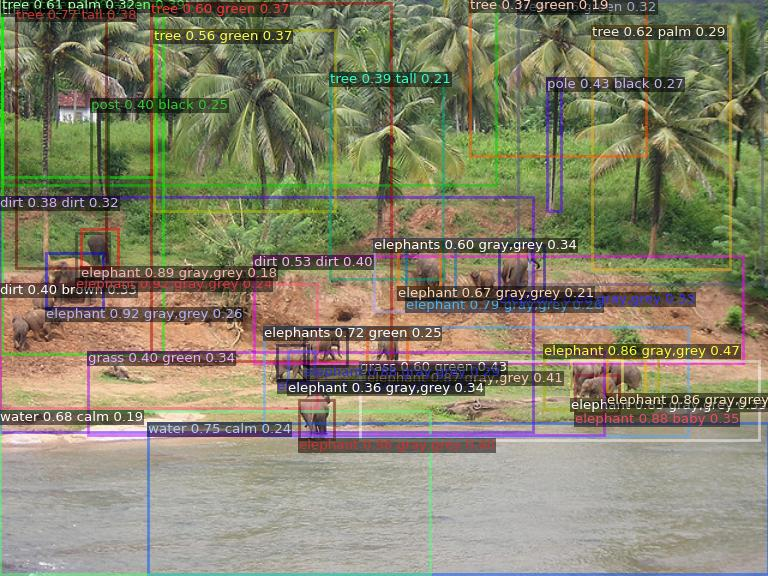

Question: ['are there elephants in the image ?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['how many elephants can you see?']
prediction from LXMERT GQA: crane
prediction from quantised GQA: crane


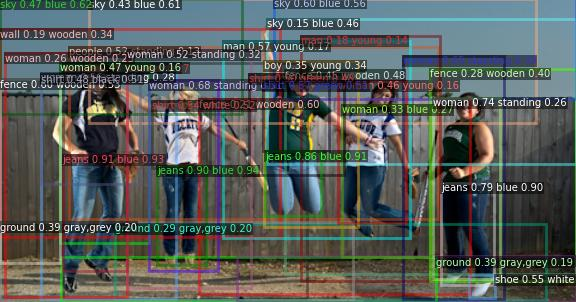

Question: ['what is there in the image ?']
prediction from LXMERT GQA: fence
prediction from quantised GQA: fence
Question: ['how many humans ?']
prediction from LXMERT GQA: polo shirt
prediction from quantised GQA: polo shirt
Question: ['do you see girls?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['do you see boys ?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['are they happy ?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['what are they doing ?']
prediction from LXMERT GQA: playing
prediction from quantised GQA: playing


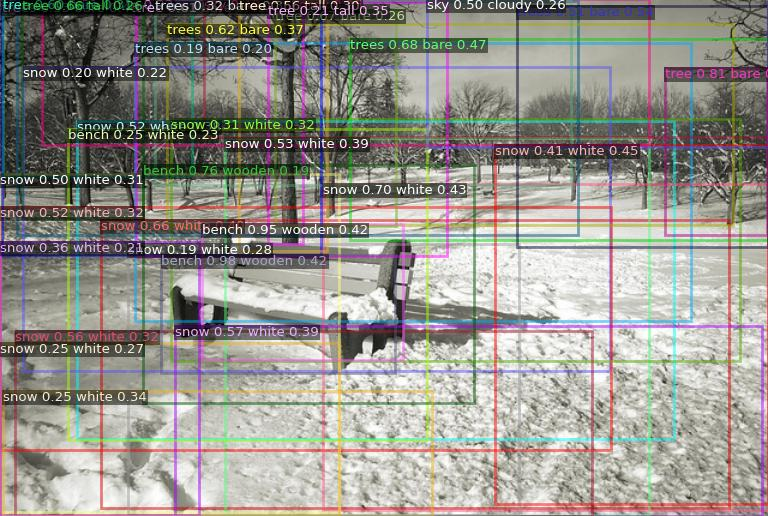

Question: ['what color is in the image ?']
prediction from LXMERT GQA: white
prediction from quantised GQA: white
Question: ['is there a sky ?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['what color is the sky?']
prediction from LXMERT GQA: white
prediction from quantised GQA: white
Question: ['are there trees ?']
prediction from LXMERT GQA: yes
prediction from quantised GQA: yes
Question: ['what color are the trees ?']
prediction from LXMERT GQA: dark
prediction from quantised GQA: dark


In [ ]:
URL1 = "http://images.cocodataset.org/train2017/000000002315.jpg" #--- elephants
URL2 = "http://images.cocodataset.org/train2017/000000001943.jpg" # --- humans
URL3 = "http://images.cocodataset.org/train2017/000000001792.jpg" # ---	snow
# Preprocess the image and get output dictionary
images, sizes, scales_yx = image_preprocess(URL1)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# Define questions for the image
test_questions_for_url1 = ["are there elephants in the image ?", "how many elephants can you see?"]

normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

# Uncomment below lines for visualization if needed
frcnn_visualizer = SingleImageViz(URL1, id2obj=objids, id2attr=attrids)
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())
# Run inference for each question and record predictions
for test_question in test_questions_for_url1:
    test_question = [test_question]
    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    # Run original LXMERT
    lxmert_output = lxmert_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Run pruned/quantized LXMERT
    quantized_output = quantized_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Print the index of the last processed item
      # get prediction
    lxmert_pred_gqa = lxmert_output["question_answering_score"].argmax(-1)
    quantised_pred_gqa = quantized_output["question_answering_score"].argmax(-1)

    print("Question:", test_question)
    print("prediction from LXMERT GQA:", gqa_answers[lxmert_pred_gqa])
    print("prediction from quantised GQA:", gqa_answers[quantised_pred_gqa])
print("=================================")


# Preprocess the image and get output dictionary
images, sizes, scales_yx = image_preprocess(URL2)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# Define questions for the image
test_questions_for_url2 = ["what is there in the image ?", "how many humans ?", "do you see girls?", "do you see boys ?", "are they happy ?", "what are they doing ?"]
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")


# Uncomment below lines for visualization if needed
frcnn_visualizer = SingleImageViz(URL2, id2obj=objids, id2attr=attrids)
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())
# Run inference for each question and record predictions
for test_question in test_questions_for_url2:
    test_question = [test_question]
    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    # Run original LXMERT
    lxmert_output = lxmert_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Run pruned/quantized LXMERT
    quantized_output = quantized_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Print the index of the last processed item
      # get prediction
    lxmert_pred_gqa = lxmert_output["question_answering_score"].argmax(-1)
    quantised_pred_gqa = quantized_output["question_answering_score"].argmax(-1)

    print("Question:", test_question)
    print("prediction from LXMERT GQA:", gqa_answers[lxmert_pred_gqa])
    print("prediction from quantised GQA:", gqa_answers[quantised_pred_gqa])
print("=================================")



# Preprocess the image and get output dictionary
images, sizes, scales_yx = image_preprocess(URL3)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# Define questions for the image
test_questions_for_url3 = ["what color is in the image ?", "is there a sky ?", "what color is the sky?", "are there trees ?", "what color are the trees ?"]

normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

# Uncomment below lines for visualization if needed
frcnn_visualizer = SingleImageViz(URL3, id2obj=objids, id2attr=attrids)
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())
# Run inference for each question and record predictions
for test_question in test_questions_for_url3:
    test_question = [test_question]
    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    # Run original LXMERT
    lxmert_output = lxmert_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Run pruned/quantized LXMERT
    quantized_output = quantized_model(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # Print the index of the last processed item
      # get prediction
    lxmert_pred_gqa = lxmert_output["question_answering_score"].argmax(-1)
    quantised_pred_gqa = quantized_output["question_answering_score"].argmax(-1)

    print("Question:", test_question)
    print("prediction from LXMERT GQA:", gqa_answers[lxmert_pred_gqa])
    print("prediction from quantised GQA:", gqa_answers[quantised_pred_gqa])
print("=================================")

mobile application

In [ ]:
!pip install onnx onnxruntime onnx-simplifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
! ls /content/drive/MyDrive/lxmert

demo.ipynb	    modeling_frcnn.py	 __pycache__  requirements.txt	visualizing_image.py
extracting_data.py  processing_image.py  README.md    utils.py


In [ ]:
!pip install torch onnx onnxruntime
